2023.05.22 박진윤 선임연구원, 태안군 인공지능유합산업진흥원

## 작업환경 확인

In [1]:
# 현재 위치 확인
!pwd

/tf/repos/08_PRL_paperwork/model_training


In [2]:
# 학습 할때 몇 번째 gpu를 사용할것인지 설정
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used

In [3]:
# 경고 무시
import warnings
warnings.filterwarnings('ignore')
curdir = os.getcwd()
print(curdir)

/tf/repos/08_PRL_paperwork/model_training


In [4]:
# 서버 이름
import socket
hostname = socket.gethostname()
print(hostname)

659ef767da4a


In [5]:
def createFolder(directory):
    try:
        if os.path.exists(directory):
            print('Already Exists')
        if not os.path.exists(directory):
            os.makedirs(directory)
            print('Sucess creating directory.' + directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

## 필요 라이브러리 import

In [6]:
import sys
sys.path.append(os.pardir)
sys.path.append('./common')

In [7]:
%matplotlib inline
import glob
import tensorflow as tf
import numpy as np
import pandas as pd
import time
from tqdm import tqdm 
import pickle

from Quaternion import *
from  DDUtil import GetTimeString
from  DDUtil import MakeDir
from  DDUtil import *
from DataSet2 import skipper
from DataSet2 import NormalizeData
from DataSet2 import GetSizeForBatch
import DataSet2
import DataSet2 as motion

In [8]:
from transformer import MultiHeadSelfAttention
from transformer import TransformerBlock
#from transformer import TokenAndPositionEmbedding
from transformer import TokenAndPositionEmbedding2

In [9]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Bidirectional
from tensorflow.keras.layers import Flatten, Masking, Add

from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import SimpleRNN, AveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K

In [10]:
from Attention import Attention

from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import random
import math

In [11]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import LabelBinarizer
# from keras_flops import get_flops #pip install keras-flops

In [12]:
tstring = GetTimeString()
print(tstring)

20230615_084138


In [13]:
np.random.seed(1214)

In [14]:
# 텐서플로우 버전이 2.3.0 이 아니면 중단
print(tf.__version__)
# assert tf.__version__=='2.3.0'

2.8.0


## 데이터 불러오기

In [15]:
outdir_pickle = './pickle'
fn_pickle_pub = '{}/0531_elderly_youtube_class4_len_all_pub.pickle'.format(outdir_pickle)
print(fn_pickle_pub)

./pickle/0531_elderly_youtube_class4_len_all_pub.pickle


In [16]:
# change all the necessary information for the according dataset
dataset_name = fn_pickle_pub.split('/')[-1].split('_')[1]
print(f'This notebook is working on {dataset_name} dataset')

if dataset_name == 'UTK':
    spine_joint_index = 1 
    num_joints = 20
    nbsample_crop = 70 
    right_hip_joint_index = 16
    left_hip_joint_index = 12
    mid_hip_joint_index = 0
    neck_joint_index = 2
elif dataset_name == 'FLO':
    spine_joint_index = 2 
    num_joints = 15
    nbsample_crop = 35 
    right_hip_joint_index = 12
    left_hip_joint_index = 9
    mid_hip_joint_index = 2
    neck_joint_index = 1
elif dataset_name == 'MSRA':
    spine_joint_index = 1
    num_joints = 20
    nbsample_crop = 70 
    right_hip_joint_index = 4
    left_hip_joint_index = 5
    mid_hip_joint_index = 6
    neck_joint_index = 2
elif dataset_name == 'elderly':
    spine_joint_index = 7 
    num_joints = 17
    nbsample_crop = 60 
    right_hip_joint_index = 1
    left_hip_joint_index = 4
    mid_hip_joint_index = 0
    neck_joint_index = 8
else: #H36M
    spine_joint_index = 7 
    num_joints = 17
    nbsample_crop = 100 
    right_hip_joint_index = 1
    left_hip_joint_index = 4
    mid_hip_joint_index = 0
    neck_joint_index = 8

seq_length = nbsample_crop
pad_value = 0

In [17]:
createFolder(f'./out/{dataset_name}/')

Already Exists


In [18]:
loadFromPickle = True  #True #False

In [19]:
if loadFromPickle:
    if os.path.exists(fn_pickle_pub):
        print('{} exists....OK'.format(fn_pickle_pub))

        print('load from pickle files')
        file = open(fn_pickle_pub, 'rb')
        data = pickle.load(file)
        file.close()
        print(np.shape(data))
        dataset = data[0]
        labels = data[1]  
        class_name_pub = data[2]  
        dname = data[3] 
        tstring = data[4]

./pickle/0531_elderly_youtube_class4_len_all_pub.pickle exists....OK
load from pickle files
(5,)


In [20]:
class_name_pub

['C00', 'C01', 'C02', 'C03']

In [21]:
n_classes = len(class_name_pub)
n_classes

4

In [22]:
np.shape(dataset[0]), np.shape(labels[0])

((60, 51), (4,))

In [23]:
class MyPaddingSeq3d():
    def __init__(self, maxlen=None, pad_value=0.0):
        super(MyPaddingSeq3d, self).__init__()
        self.maxlen  = maxlen 
        self.pad_value = pad_value
    
    def ddd(self, sequences):
        sequences_out = []
        
        seq_num = len(sequences)
        print(seq_num)
        for i in range(seq_num):
            seq_1 = sequences[i]
            seq_1 = list(seq_1)
            #print(len(seq_1))
            dim = np.shape(seq_1[-1])[0]
            if len(seq_1) < self.maxlen:
                p = np.full((self.maxlen - len(seq_1), dim), self.pad_value)
                s = np.vstack((seq_1, p))
                sequences_out.append(s)
                
            elif len(seq_1) >= self.maxlen:
                x = seq_1[:self.maxlen]
                sequences_out.append(x)
            
        return np.array(sequences_out)

In [24]:
pad = MyPaddingSeq3d(maxlen = nbsample_crop, pad_value = pad_value)

In [ ]:
if dataset_name in['MSRA', 'FLO', 'UTK']:
    padded_data = pad.ddd(dataset)
    print('padded')
else:
    padded_data = dataset.copy()
    print('not padded')

``` python
((14280, 100, 75), (14280, 10), (6243, 100, 75), (6243, 10))
```

In [27]:
np.shape(padded_data), np.shape(labels)

((1265, 60, 51), (1265, 4))

In [28]:
np.shape(padded_data[:, :, 1:1*4])

(1265, 60, 3)

In [29]:
padded_data[0].shape

(60, 51)

In [30]:
for i in range(len(class_name_pub)):
    print(i, class_name_pub[i])

0 C00
1 C01
2 C02
3 C03


```
(AS1) Horizontal arm wave, hammer, forward punch, high throw, hand clap, bend, tennis serve, pickup & throw 

(AS2) high arm wave, hand catch, draw x, draw tick, draw circle, two hand wave, forward kick, side boxing 

(AS3) high thorw, forward kick, side kick, jogging, tennis swing, tennis serve, gold swing, pickup & throw
```

In [31]:
case = 'AS2'

In [32]:
if dataset_name == 'MSRA':
    if case == 'AS1':
        idx = [12, 7, 4, 11, 9, 0, 17, 14]
    elif case == 'AS2':
        idx = [10, 8, 3, 2, 1, 19, 5, 15]
    elif case == 'AS3':
        idx = [11, 5, 16, 13, 17, 18, 6, 14]

    print(idx)
else:
    case = 'None'
    print('passed on choosing action set')

passed on choosing action set


In [33]:
# np.argmax(labels[0]) in idx
# padded_data[0]
# padded_data.shape, labels.shape

In [34]:
k = 0
for sample in range(len(padded_data)):
    if dataset_name == 'MSRA':
        if np.argmax(labels[sample]) in idx:
            temp = [padded_data[sample]]
            lbl = labels[sample]
    #         print(np.shape(temp))
        else:
            continue
    else:
        temp = [padded_data[sample]]
        lbl = labels[sample]
        
    if k == 0:
        temp_stack = temp
        lbl_stack = lbl
        k+=1
    else:
        temp_stack = np.vstack((temp_stack, temp))
        lbl_stack = np.vstack((lbl_stack, lbl))

padded_data_case = temp_stack
labels_case = lbl_stack
print('-------------------------------------------')
print('selected actions', np.shape(padded_data_case), np.shape(labels_case))

-------------------------------------------
selected actions (1265, 60, 51) (1265, 4)


In [35]:
datadim = np.shape(padded_data_case[0])[-1]
datadim

51

In [36]:
n_timesteps, n_features, n_outputs = seq_length, datadim, n_classes
print(n_timesteps, n_features, n_outputs)

60 51 4


## 학습

In [37]:
to_Train = True

In [38]:
num_layers = 2   # no of stacks
training_epochs = 100

In [39]:
# 221226
# https://velog.io/@noooooh_042/논문-구현GoogleNetv1
def inception(x_in, x1_f,x3r_f,x3_f,x5r_f,x5_f,po):
    x1 = MaxPooling1D(pool_size=3,strides=1,padding = 'SAME')(x_in)
    x1 = Conv1D(filters= po,kernel_size=1,padding="SAME")(x1)
    x1 = Activation('relu')(x1)

    x2 = Conv1D(filters=x5r_f,kernel_size=1,padding="SAME")(x_in)
    x2 = Conv1D(filters=x5_f,kernel_size=5,padding="SAME")(x2)
    x2 = Activation('relu')(x2)

    x3 = Conv1D(filters=x3r_f,kernel_size=1,padding="SAME")(x_in)
    x3 = Conv1D(filters=x3_f,kernel_size=3,padding="SAME")(x3)
    x3 = Activation('relu')(x3)

    x4 = Conv1D(filters=x1_f,kernel_size=1,padding="SAME")(x_in)
    x4 = Activation('relu')(x4)

    out = Concatenate()([x1,x2,x3,x4])
    return out

In [40]:
n_outputs

4

https://github.com/keras-team/keras-io/blob/master/examples/nlp/text_classification_with_transformer.py https://keras.io/examples/nlp/text_classification_with_transformer/

In [57]:
# 원본
def make_transformer(maxlen, data_dim, embed_dim, num_heads, ff_dim, return_logit_only=False, return_weights=False):
    #maxlen =  200  # Only consider the first 200 words of each movie review
    # data_dim = 6
    #inputs = layers.Input(shape=(maxlen,))
    
    inputs = layers.Input(shape=(maxlen, data_dim )) 
    if False:
        embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
        x = embedding_layer(inputs)
    else:

        embedding_layer = TokenAndPositionEmbedding2(maxlen, embed_dim) #100,  32 (<--- was 6)
        x = embedding_layer(inputs)
        #x = layers.Dense(embed_dim, activation="relu")(inputs)


    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    vattn_weights =[]
    if return_weights:
        x, attn_weights1 = transformer_block(x,training = True, return_weights = return_weights)#
        vattn_weights.append(attn_weights1)
        
        x, attn_weights2 = transformer_block(x,training=True, return_weights = return_weights)#
        vattn_weights.append(attn_weights2)
        
        x, attn_weights3 = transformer_block(x,training=True, return_weights = return_weights)#
        vattn_weights.append(attn_weights3)
        
        x, attn_weights4 = transformer_block(x,training=True, return_weights = return_weights)#
        vattn_weights.append(attn_weights4)
        
    else:
        x = transformer_block(x,training = True, return_weights = return_weights)#

        x = transformer_block(x,training=True, return_weights = return_weights)#
        x = transformer_block(x,training=True, return_weights = return_weights)
        x = transformer_block(x,training=True, return_weights = return_weights)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.2)(x)   #0.1
    #x = layers.Dense(20, activation="relu")(x)
    #x = layers.Dropout(0.1)(x)
    
    if return_logit_only:
        outputs = x
    else:
        outputs = layers.Dense(n_classes, activation="softmax")(x)
        
    # transformer_block._name
    model = keras.Model(inputs=inputs, outputs=outputs)
    if return_weights:
        
        return model, vattn_weights
    else:
        return model

In [58]:
def MakeModel(celltype):
    if celltype=='ResNet':
        # https://github.com/hfawaz/dl-4-tsc/blob/master/classifiers/resnet.py
        n_feature_maps = 64

        input_layer = Input((n_timesteps,n_features))

        # BLOCK 1

        conv_x = Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
        conv_x = BatchNormalization()(conv_x)
        # conv_x = Dense(n_feature_maps, activation='relu')(conv_x)
        conv_x = Activation('relu')(conv_x)

        conv_y = Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
        conv_y = BatchNormalization()(conv_y)
        conv_y = Activation('relu')(conv_y)

        conv_z = Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
        conv_z = BatchNormalization()(conv_z)

        # expand channels for the sum
        shortcut_y = Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
        shortcut_y = BatchNormalization()(shortcut_y)

        output_block_1 = tf.keras.layers.add([shortcut_y, conv_z])
        output_block_1 = Activation('relu')(output_block_1)

        # BLOCK 2

        conv_x = Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
        conv_x = BatchNormalization()(conv_x)
        conv_x = Activation('relu')(conv_x)

        conv_y = Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
        conv_y = BatchNormalization()(conv_y)
        conv_y = Activation('relu')(conv_y)

        conv_z = Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
        conv_z = BatchNormalization()(conv_z)

        # expand channels for the sum
        shortcut_y = Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
        shortcut_y = BatchNormalization()(shortcut_y)

        output_block_2 = tf.keras.layers.add([shortcut_y, conv_z])
        output_block_2 = Activation('relu')(output_block_2)

        # BLOCK 3

        conv_x = Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
        conv_x = BatchNormalization()(conv_x)
        conv_x = Activation('relu')(conv_x)

        conv_y = Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
        conv_y = BatchNormalization()(conv_y)
        conv_y = Activation('relu')(conv_y)

        conv_z = Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
        conv_z = BatchNormalization()(conv_z)

        # no need to expand channels because they are equal
        shortcut_y = BatchNormalization()(output_block_2)

        output_block_3 = tf.keras.layers.add([shortcut_y, conv_z])
        output_block_3 = Activation('relu')(output_block_3)

        # FINAL

        gap_layer = GlobalAveragePooling1D()(output_block_3)
        gap_layer = Dropout(0.2)(gap_layer)
        gap_layer = Flatten()(gap_layer)

        output_layer = Dense(n_classes, activation='softmax')(gap_layer)

        model = Model(inputs=input_layer, outputs=output_layer)

    elif celltype=='Conv1D':
        # 221116
        model = Sequential()
        model.add(Conv1D(kernel_size=3, strides=1,filters=32, activation='relu', padding='same', input_shape=(n_timesteps,n_features)))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(kernel_size=3, strides=1,filters=64, activation='relu', padding='same'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(kernel_size=3, strides=1,filters=128, activation='relu', padding='same'))
        model.add(MaxPooling1D(pool_size=2))

        model.add(GlobalAveragePooling1D())
        model.add(Dropout(rate=0.2)) #rate = 1 - keep_prob
        # model.add(Dense(64, activation='relu'))
        model.add(Dense(n_outputs, activation='softmax'))
        
    elif celltype=='GoogleNet':
        input_data = Input((n_timesteps,n_features))

        x = Conv1D(filters=64,kernel_size=7,strides=2,padding="SAME")(input_data)
        x = MaxPooling1D(pool_size=3,strides=2,padding="SAME")(x)
        x = tf.keras.layers.LayerNormalization()(x)

        x = Conv1D(filters=64,kernel_size=1,strides=1,padding="SAME")(x)
        x = Conv1D(filters=192,kernel_size=3,strides=1,padding="SAME")(x)

        x = tf.keras.layers.LayerNormalization()(x)
        x = MaxPooling1D(pool_size=3,strides=2,padding="SAME")(x)

        x = inception(x,64,96,128,16,32,32)
        x = inception(x,128,128,192,32,96,64)

        x = MaxPooling1D(pool_size=3,strides=2,padding="SAME")(x)
        x = inception(x,192,96,208,16,48,64)

        ax1 = AveragePooling1D(pool_size=5,strides=3)(x)
        ax1 = Conv1D(filters=128,kernel_size=1,padding="SAME")(ax1)
        ax1 = Flatten()(ax1)
        ax1 = Dense(1024,activation="relu")(ax1)
        ax1 = Dropout(0.7)(ax1)
        ax1 = Dense(10,activation="softmax")(ax1)

        x = inception(x,160,112,224,24,64,64)
        x = inception(x,128,128,256,24,64,64)

        x = inception(x,112,114,288,32,64,64)

        ax2 = AveragePooling1D(pool_size=5,strides=3)(x)
        ax2 = Conv1D(filters=128,kernel_size=1,padding="SAME")(ax2)
        ax2 = Flatten()(ax2)
        ax2 = Dense(1024,activation="relu")(ax2)
        ax2 = Dropout(0.7)(ax2)
        ax2 = Dense(10,activation="softmax")(ax2)

        x = inception(x,256,160,320,32,128,128)
        x = MaxPooling1D(pool_size=3,strides=2,padding="SAME")(x)

        x = inception(x,256,160,320,32,128,128)
        x = inception(x,384,192,384,48,128,128)

        x = GlobalAveragePooling1D()(x)
        x = Dropout(0.4)(x)

        outputs = Dense(n_classes,activation="softmax")(x)

        model= tf.keras.models.Model(input_data,[outputs,ax1,ax2],name = 'googlenet')
        
    elif celltype=='LSTM':
        model = Sequential()
        model.add(LSTM(n_timesteps, return_sequences=True, input_shape=(n_timesteps,n_features)))
        model.add(LSTM(n_timesteps))
        model.add(Dropout(rate=0.2))
        model.add(Dense(100, activation='relu'))
        model.add(Dense(n_outputs, activation='softmax'))

    elif celltype=='GRU':
        model = Sequential()
        model.add(GRU(n_timesteps, return_sequences=True, input_shape=(n_timesteps,n_features)))
        model.add(GRU(n_timesteps))
        model.add(Dropout(rate=0.2))
        model.add(Dense(100, activation='relu'))
        model.add(Dense(n_outputs, activation='softmax'))

    return model

In [60]:
# 221116
model = Sequential()
model.add(Conv1D(kernel_size=3, strides=1,filters=32, activation='relu', padding='same', input_shape=(n_timesteps,n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(kernel_size=3, strides=1,filters=64, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(kernel_size=3, strides=1,filters=128, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))

model.add(GlobalAveragePooling1D())
model.add(Dropout(rate=0.2)) #rate = 1 - keep_prob
# model.add(Dense(64, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

In [61]:
model = MakeModel('LSTM')
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 60)            26880     
                                                                 
 lstm_3 (LSTM)               (None, 60)                29040     
                                                                 
 dropout_6 (Dropout)         (None, 60)                0         
                                                                 
 dense_12 (Dense)            (None, 100)               6100      
                                                                 
 dense_13 (Dense)            (None, 4)                 404       
                                                                 
Total params: 62,424
Trainable params: 62,424
Non-trainable params: 0
_________________________________________________________________
None


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


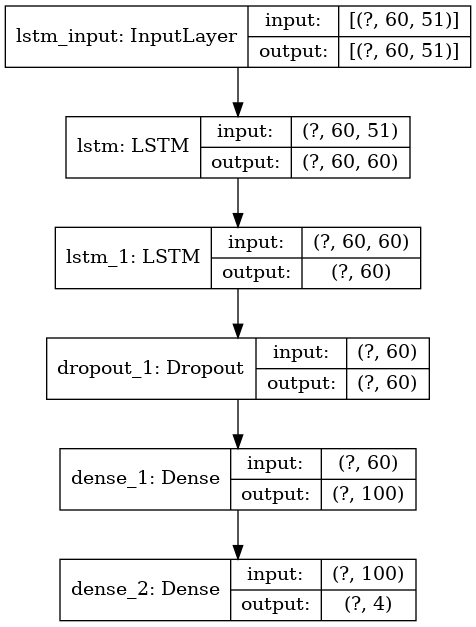

In [62]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='./model_LSTM.png', show_shapes=True)

from IPython.display import Image
Image('./model_LSTM.png')

In [63]:
# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='{}/model{}.png'.format(outDir, ttl1), show_shapes=True)

# from IPython.display import Image
# Image('{}/model{}.png'.format(outDir, ttl1))

In [64]:
lr_schedule(0)

Learning rate:  0.001


0.001

##### k-fold evaluation - training

In [65]:
n_timesteps,n_features

(60, 51)

In [66]:
Augmentation =True
# RotTest = False
# ViewTest = True #whether setting viewnorm for test data
ViewNorm = False #whether setting viewnorm for train data
aug_count = 20 #2,4,7,10,15,20

model_type = 'Transformer' #ResNet, Conv1D, GoogleNet

# split_num = 4
# num = 2
joints = 17 #MSR&UTK - 20; FLO - 15
right_hip_idx = 1 #MSR - 4; FLO - 12; UTK - 16
left_hip_idx = 4
spine_idx = 7 #MSR - 3; FLO - 2; UTK - 1
mid_hip_idx = 0
neck_idx = 8

seed_value = 1214
batch_size = 16

In [67]:
# #specified rotation
# if aug_count == 2:
#     angles = [10]
# elif aug_count == 4:
#     angles = [5,10,15]
# elif aug_count == 7:
#     angles = [3,6,9,12,15,18]
# elif aug_count == 10:
#     angles = [2,4,6,8,10,12,14,16,18]
# elif aug_count == 20:
#     angles = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]

# random rotation
# aug_count = 20
random.seed(1214)

if aug_count == 2:
    angles = [random.randint(1, 19)]
elif aug_count == 4:
    angles = []
    for i in range(aug_count-1):
        ang = random.randint(1, 19)
        angles.append(ang)
elif aug_count == 7:
    angles = []
    for i in range(aug_count-1):
        ang = random.randint(1, 19)
        angles.append(ang)
elif aug_count == 10:
    angles = []
    for i in range(aug_count-1):
        ang = random.randint(1, 19)
        angles.append(ang)
elif aug_count == 15:
    angles = []
    for i in range(aug_count-1):
        ang = random.randint(1, 19)
        angles.append(ang)
elif aug_count == 20:
    angles = []
    for i in range(aug_count-1):
        ang = random.randint(1, 19)
        angles.append(ang)
        
# angles

In [68]:
num_folds = 10

In [69]:
padded_data_case.shape, labels_case.shape

((1265, 60, 51), (1265, 4))

In [70]:
inputs = padded_data_case
targets = labels_case

In [71]:
embed_dim = 64 #32 #64 #12 #8 #16 # Embedding size for each token
num_heads = 4 #4#1 # Number of attention heads
ff_dim = embed_dim*1 #32*2*4  # Hidden layer size in feed forward network inside transformer

In [72]:
# 221122 시도
random.seed(1214)

out_dir = f'./out/{dataset_name}/'
'''
augmentation data : 180 degree augmentation only
testing data : (1) original data, (2) random rotated data 
----> should be the same testing data
'''
# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed_value)
acc_ori = list() # results from testing with original data
acc_vn_f = list() # results from testing with orient removed data-frame
acc_vn_s = list() # results from testing with orient removed data-sequence
acc_rot = list() # results from testing with random rotated data
acc_rot_s = list() # results from testing with random rotated data
acc_vrot = list() # results from testing with orient removed, random rotated data

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in tqdm(kfold.split(inputs, targets)):
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    if ViewNorm == True:
        view_inputs = ViewRot(inputs[train], joints, right_hip_idx)
    
    if Augmentation == True:
        if ViewNorm == True:
            print('.........Augmenting + View Norm train input data..........')
        else:
            print('.........Augmenting train input data..........')
        #augmentation of the train set
        rot_inputs = []
        rot_targets = []
        for idx in range(len(inputs[train])): #segment in view_inputs:
            #adding original data
            if ViewNorm == True:
                rot_inputs.append(view_inputs[idx])
            else:
                rot_inputs.append(inputs[train][idx])
            rot_targets.append(targets[train][idx])

        for idx in range(len(inputs[train])):
            for aug in angles:
                if ViewNorm == True:
                    augmented = augmentation(view_inputs[idx], aug, joints)
                else:
                    augmented = augmentation_zaxis(inputs[train][idx], aug, joints)
#                     augmented = augmentation_spine(inputs[train][idx], aug, joints, mid_hip_idx, neck_idx)
                rot_inputs.append(augmented)
                rot_targets.append(targets[train][idx])

        rot_inputs = np.array(rot_inputs)    
        rot_targets = np.array(rot_targets) 
        print('augmented input shape -> ', rot_inputs.shape)
        print('augmented target shape -> ', rot_targets.shape)
        
    else:
        if ViewNorm == True:
            print('Input orient removed train shape -> ', view_inputs.shape)
        else:
            print('Input train shape -> ', inputs[train].shape)
        print('Target train shape -> ', targets[train].shape)
        
    if model_type == 'Transformer':
        model, atten_wieghts = make_transformer(nbsample_crop, datadim, embed_dim, num_heads, ff_dim, return_weights = True)
    else:
        model = MakeModel(model_type)
    
#     print(model.summary())
    # Compile the model
    model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(lr=lr_schedule(0)), 
                  metrics=['accuracy'])
#     flops = get_flops(model, batch_size=16)
#     print(f"FLOPS: {flops / 10 ** 9:.03} G")
#     print(f"FLOPS: {flops} ")
        
    if Augmentation == True:
        # Fit data to model
        num_aug = int(rot_inputs.shape[0]/inputs[train].shape[0])
        print(num_aug)
        history = model.fit(rot_inputs, rot_targets,
                  batch_size=batch_size,
                  epochs=100,
                  verbose=False)
        if model_type == 'Transformer':
            model.save(out_dir+f'{dataset_name}_aug{aug_count}_{model_type}_{fold_no}-fold')
        else:
            model.save(out_dir+f'{dataset_name}_aug{aug_count}_{model_type}_{fold_no}-fold.h5')
#         flops = get_flops(model, batch_size=16)
    
    else:
        num_aug = 0
        if ViewNorm == True:
            history = model.fit(view_inputs, targets[train],
                      batch_size=batch_size,
                      epochs=100,
                      verbose=False)
            if model_type == 'Transformer':
                model.save(out_dir+f'{dataset_name}_aug{aug_count}_{model_type}_{fold_no}-fold')
            else:
                model.save(out_dir+f'{dataset_name}_aug{aug_count}_{model_type}_{fold_no}-fold.h5')
#             flops = get_flops(model, batch_size=16)
        else:
            history = model.fit(inputs[train], targets[train],
                      batch_size=batch_size,
                      epochs=100,
                      verbose=False)
            if model_type == 'Transformer':
                model.save(out_dir+f'{dataset_name}_aug{aug_count}_{model_type}_{fold_no}-fold')
            else:
                model.save(out_dir+f'{dataset_name}_aug{aug_count}_{model_type}_{fold_no}-fold.h5')
#             flops = get_flops(model, batch_size=16)

#     print(f"FLOPS: {flops / 10 ** 9:.03} G")
#     print(f"FLOPS: {flops} ")
### -----------------------------t-e-s-t----------------------------------- ###
    print('---Testing with original data---')
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    acc_ori.append(scores[1] * 100)
    print(f'Score for fold {fold_no}: {model.metrics_names[1]} of {scores[1]*100}%')
    
    print('---Testing with orient removed data(sequence)---')
    view_test = ViewRot(inputs[test], joints, right_hip_idx)
    scores = model.evaluate(view_test, targets[test], verbose=0)
    acc_vn_s.append(scores[1] * 100)
    print(f'Score for fold {fold_no}: {model.metrics_names[1]} of {scores[1]*100}%')
    
    print('---Testing with random rotated data (spine)---')
    rot_s_test = []
    for idx in range(len(inputs[test])):
        ang = random.randint(0, 20)
        augmented = augmentation_spine(inputs[test][idx], ang, joints, mid_hip_idx, neck_idx)
        rot_s_test.append(augmented)
    rot_s_test = np.array(rot_s_test)
    
    scores = model.evaluate(rot_s_test, targets[test], verbose=0)
    acc_rot_s.append(scores[1] * 100)
    print(f'Score for fold {fold_no}: {model.metrics_names[1]} of {scores[1]*100}%')
    
    print('---Testing with random rotated data (zaxis)---')
    rot_test = []
    for idx in range(len(inputs[test])):
        ang = random.randint(0, 20)
        augmented = augmentation_zaxis(inputs[test][idx], ang, joints)
        rot_test.append(augmented)
    rot_test = np.array(rot_test)
    
    scores = model.evaluate(rot_test, targets[test], verbose=0)
    acc_rot.append(scores[1] * 100)
    print(f'Score for fold {fold_no}: {model.metrics_names[1]} of {scores[1]*100}%')
    
#     print('---Testing with orient removed, random rotated data---')
#     rot_test = []
#     for idx in range(len(inputs[test])):
#         ang = random.randint(0, 20)
#         augmented = augmentation(view_test[idx], ang, joints)
#         rot_s_test.append(augmented)
#     rot_test = np.array(rot_test)
    
#     scores = model.evaluate(rot_test, targets[test], verbose=0)
#     acc_vrot.append(scores[1] * 100)
#     print(f'Score for fold {fold_no}: {model.metrics_names[1]} of {scores[1]*100}%')
    
    # Increase fold number
    fold_no = fold_no + 1
    break

0it [00:00, ?it/s]

------------------------------------------------------------------------
Training for fold 1 ...
.........Augmenting train input data..........
augmented input shape ->  (22760, 60, 51)
augmented target shape ->  (22760, 4)
Learning rate:  0.001
20


INFO:tensorflow:Assets written to: ./out/elderly_youtube/elderly_youtube_aug20_Transformer_1-fold/assets


INFO:tensorflow:Assets written to: ./out/elderly_youtube/elderly_youtube_aug20_Transformer_1-fold/assets


---Testing with original data---
Score for fold 1: accuracy of 92.91338324546814%
---Testing with orient removed data(sequence)---
Score for fold 1: accuracy of 94.48819160461426%
---Testing with random rotated data (spine)---
Score for fold 1: accuracy of 66.1417305469513%
---Testing with random rotated data (zaxis)---


1it [54:07, 3247.13s/it]

Score for fold 1: accuracy of 87.4015748500824%
------------------------------------------------------------------------
Training for fold 2 ...
.........Augmenting train input data..........
augmented input shape ->  (22760, 60, 51)
augmented target shape ->  (22760, 4)
Learning rate:  0.001
20


1it [1:27:36, 5256.34s/it]

KeyboardInterrupt



In [ ]:
Augmentation, ViewNorm, aug_count, dataset_name, model_type, case

In [ ]:
np.mean(acc_ori), np.mean(acc_vn_s), np.mean(acc_rot), np.mean(acc_rot_s), np.mean(acc_vrot)

In [ ]:
# sss

In [ ]:
# pad_value, aug_count, Augmentation, RotTest, ViewNorm, ViewTest, seed_value

In [ ]:
# fig, ax1 = plt.subplots()

# x = np.arange(1, 11, 1)

# ax2 = ax1.twinx()
# ax1.plot(x, acc_per_fold, 'g.-')
# ax2.plot(x, roc_per_fold, 'b.-')

# ax1.set_xlabel('K-fold')
# ax1.set_xlim([1,10])
# ax1.set_ylabel('Accuracy', color='g')
# ax1.set_ylim([0, 110])
# ax2.set_ylabel(' ROC-AUC score ', color='b')
# ax2.set_ylim([0, np.max(loss_per_fold)+0.5])

# plt.show()

## ROC-AUC graph
- for multiclass ROC-AUC
https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [ ]:
# label_binarizer = LabelBinarizer().fit(targets[train])
# y_onehot_test = label_binarizer.transform(targets[test])
# y_score = model.predict(inputs[test], verbose=1)
# y_score = model.predict(inputs[test], verbose=1)
# y_onehot_test.shape  # (n_samples, n_classes)

In [ ]:
# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# # fpr, tpr, _ = roc_curve(targets[test], predy)
# fpr, tpr, _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
# roc_auc = auc(fpr, tpr)

# roc_auc

In [ ]:
# plt.figure()
# lw = 2
# plt.plot(
#     fpr,
#     tpr,
#     color="darkorange",
#     lw=lw,
#     label="ROC curve (area = %0.2f)" % roc_auc,
# )
# plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
# plt.xlim([-0.005, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("Receiver operating characteristic example")
# plt.legend(loc="lower right")
# plt.show()

#### save training results to txt

In [ ]:
tstring = GetTimeString()
print(tstring), num_aug

In [ ]:
print('case: \t\t', case)    
print('pad_value: \t', pad_value)
print('seed_value: \t', seed_value)
print('Augmentation: \t', Augmentation)
# print('RotTest: \t', RotTest)
print('ViewNorm: \t', ViewNorm)
# print('ViewNorm: \t', ViewTest)
print('num_aug: \t', num_aug)
print('batch_size: \t', batch_size)
# print('mean acc: \t', np.mean(acc_per_fold))
# print('mean ROC-AUC: \t', np.mean(roc_auc*100))

In [ ]:
result_txt = f'./1224_{dataset_name}_results_information.txt' # Conv1d에서 viewNorm결과들 넣은 파일
result_txt = f'./0102_{model_type}_{dataset_name}_results_information.txt' # Resnet50

In [ ]:
result_txt

In [ ]:
# if not os.path.isfile(result_txt):
#     with open(result_txt, 'w') as f:
#         f.write(str(case) + '\t')
#         f.write(str(pad_value) + '\t')
#         f.write(str(seed_value) + '\t')
#         f.write(str(Augmentation) + '\t')
# #         f.write(str(RotTest) + '\t')
#         f.write(str(ViewNorm) + '\t')
# #         f.write(str(ViewTest) + '\t')
#         f.write(str(num_aug) + '\t')
#         f.write(str(batch_size) + '\t')
#         f.write(str(np.mean(acc_per_fold)) + '\t')
# #         f.write(str(np.mean(roc_auc*100)) + '\t')
#         f.write(str(tstring) + '\t')
#         f.write('\n')
#     print('Made new txt file')
# else:
#     with open(result_txt, 'a') as f:
#         f.write(str(case) + '\t')
#         f.write(str(pad_value) + '\t')
#         f.write(str(seed_value) + '\t')
#         f.write(str(Augmentation) + '\t')
# #         f.write(str(RotTest) + '\t')
#         f.write(str(ViewNorm) + '\t')
# #         f.write(str(ViewTest) + '\t')
#         f.write(str(num_aug) + '\t')
#         f.write(str(batch_size) + '\t')
#         f.write(str(np.mean(acc_per_fold)) + '\t')
# #         f.write(str(np.mean(roc_auc*100)) + '\t')
#         f.write(str(tstring) + '\t')
#         f.write('\n')
#     print('Added information to txt file')

In [ ]:
if not os.path.isfile(result_txt):
    with open(result_txt, 'w') as f:
        f.write(str(case) + '\t')
        f.write(str(pad_value) + '\t')
        f.write(str(seed_value) + '\t')
        f.write(str(Augmentation) + '\t')
        f.write(str(ViewNorm) + '\t')
        f.write(str(num_aug) + '\t')
        f.write(str(batch_size) + '\t')
        f.write(str(np.mean(acc_ori)) + '\t')
        f.write(str(np.mean(acc_vn)) + '\t')
        f.write(str(np.mean(acc_rot)) + '\t')
        f.write(str(np.mean(acc_vrot)) + '\t')
        f.write(str(tstring) + '\t')
        f.write('\n')
    print('Made new txt file')
else:
    with open(result_txt, 'a') as f:
        f.write(str(case) + '\t')
        f.write(str(pad_value) + '\t')
        f.write(str(seed_value) + '\t')
        f.write(str(Augmentation) + '\t')
        f.write(str(ViewNorm) + '\t')
        f.write(str(num_aug) + '\t')
        f.write(str(batch_size) + '\t')
        f.write(str(np.mean(acc_ori)) + '\t')
        f.write(str(np.mean(acc_vn)) + '\t')
        f.write(str(np.mean(acc_rot)) + '\t')
        f.write(str(np.mean(acc_vrot)) + '\t')
        f.write(str(tstring) + '\t')
        f.write('\n')
    print('Added information to txt file')

In [ ]:
result_txt2 = f'./0102_{model_type}_{dataset_name}_accloss_information.txt'

In [ ]:
result_txt2

In [ ]:
# if not os.path.isfile(result_txt2):
#     with open(result_txt2, 'w') as f:
#         f.write(str(tstring) + '\t')
#         for i in range(num_folds):
#             f.write(str(acc_per_fold[i]) + '\t')
#         for i in range(num_folds):
#             f.write(str(roc_auc*100) + '\t')
#         f.write('\n')
#     print('Made new txt file')
# else:
#     with open(result_txt2, 'a') as f:
#         f.write(str(tstring) + '\t')
#         for i in range(num_folds):
#             f.write(str(acc_per_fold[i]) + '\t')
#         for i in range(num_folds):
#             f.write(str(roc_auc*100) + '\t')
#         f.write('\n')
#     print('Added information to txt file')

In [ ]:
if not os.path.isfile(result_txt2):
    with open(result_txt2, 'w') as f:
        f.write(str(tstring) + '\t')
        for i in range(num_folds):
            f.write(str(acc_ori[i]) + '\t')
        for i in range(num_folds):
            f.write(str(acc_vn[i]) + '\t')
        for i in range(num_folds):
            f.write(str(acc_rot[i]) + '\t')
        for i in range(num_folds):
            f.write(str(acc_vrot[i]) + '\t')
        f.write('\n')
    print('Made new txt file')
else:
    with open(result_txt2, 'a') as f:
        f.write(str(tstring) + '\t')
        for i in range(num_folds):
            f.write(str(acc_ori[i]) + '\t')
        for i in range(num_folds):
            f.write(str(acc_vn[i]) + '\t')
        for i in range(num_folds):
            f.write(str(acc_rot[i]) + '\t')
        for i in range(num_folds):
            f.write(str(acc_vrot[i]) + '\t')
        f.write('\n')
    print('Added information to txt file')

In [ ]:
# print(test_ang), len(test_ang[:23])

In [ ]:
# print(test_ang[23:46]), len(test_ang[23:46])

## attention
* https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html
* https://github.com/dalek7/selfattention.git
* https://archive.is/P0LhI
* https://pathtopioneer.com/blog/2020/06/7-6
* huggingface https://huggingface.co/keras-io/timeseries_transformer_classification

In [696]:
weights = model.get_weights()

In [697]:
np.shape(weights)

(21,)

In [698]:
inputs = layers.Input(shape=(seq_length, datadim)) #data_dim
model_attn1 = keras.Model(inputs=model.inputs, outputs=atten_wieghts)
model_attn1.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 60, 51)]     0           []                               
                                                                                                  
 token_and_position_embedding2_  (None, 60, 64)      7168        ['input_3[0][0]']                
 2 (TokenAndPositionEmbedding2)                                                                   
                                                                                                  
 TransformerBlock_64_4_64 (Tran  ((None, 60, 64),    25216       ['token_and_position_embedding2_2
 sformerBlock)                   (None, 4, None, No              [0][0]',                         
                                ne))                              'TransformerBlock_64_4_64[

In [699]:
tf.keras.utils.plot_model(model_attn1, to_file='model_attn1.png', show_shapes=True, dpi=150)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [700]:
layer_no = 0

In [701]:
aug = [[] for i in range(5)]
for ang in range(5):
    for i in range(len(padded_data_case[test])):
        augmented = augmentation_zaxis(padded_data_case[test][i], ang*4, joints)
        aug[ang].append(augmented)
    aug[ang] = np.array(aug[ang])
aug = np.array(aug)

In [702]:
aug.shape

(5, 127, 60, 51)

In [703]:
aa = model.predict(padded_data_case[test])

In [766]:
idx_vis = 125 ##88
aa[idx_vis][np.argmax(aa[idx_vis])], np.argmax(aa[idx_vis]), np.argmax(labels_case[test][idx_vis]), np.argmax(aa[idx_vis]) ==np.argmax(labels_case[test][idx_vis])

(0.9995035, 3, 3, True)

4/4 [==============================] - 0s 9ms/step


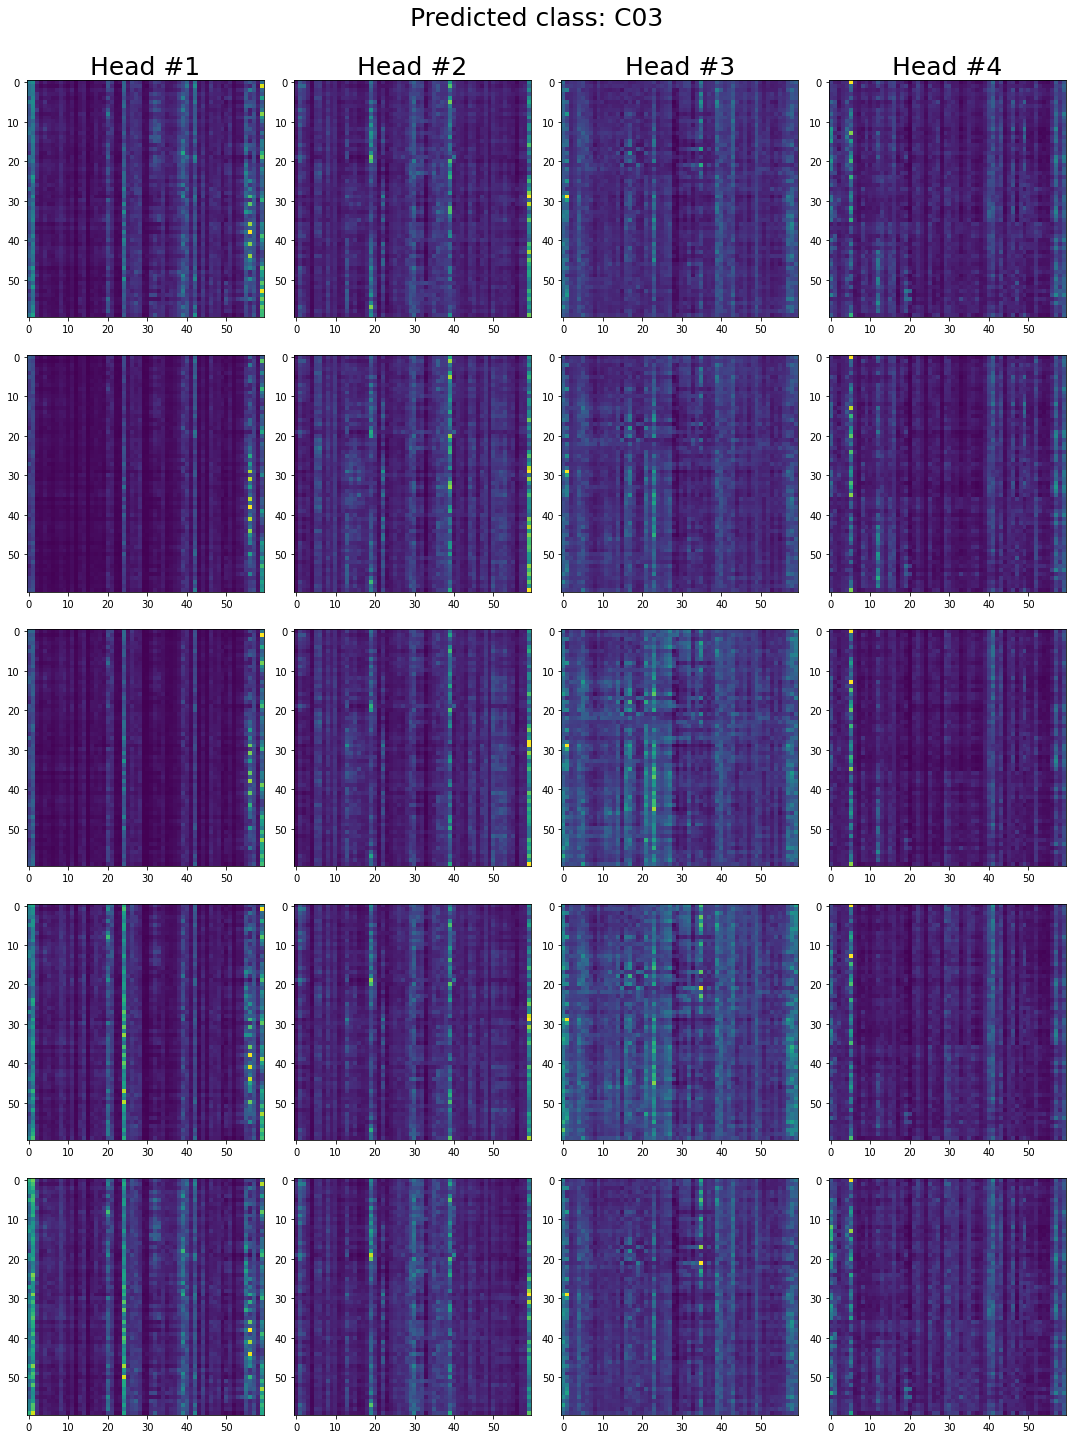

In [767]:
fig, ax = plt.subplots(5, 4, figsize=(15,20))  # Set up the subplot grid

for h in range(5):
    attn1 = model_attn1.predict(aug[h],verbose=1) # batch_size=1, 
    attn1 = np.array(attn1)
    attn_vis1 = attn1[layer_no][idx_vis]
    for j in range(4):
        ax[h, j].matshow(attn_vis1[j], cmap='viridis')  # Plot on the h-th subplot
        ax[h, j].tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False)
        ax[h, j].xaxis.set_ticks_position('bottom')
        if h == 0:
            ax[h, j].set_title(f'Head #{j+1}', fontsize = 25)  # Optional title for each subplot

plt.suptitle(f'Predicted class: {class_name_pub[np.argmax(aa[idx_vis])]}', y=1, fontsize = 25)
plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area
plt.savefig(f'../paper_figure/attention_graph/attention_graph_{idx_vis}.svg') #, dpi = 150)
plt.show()  # Display the plot

In [709]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

In [710]:
# for i in range(5):
#     aug[i] = ScaleNorm(aug[i], joints, 10)
#     aug[i] = AxisNorm(aug[i], joints, 7)

In [711]:
# joint connection of h36m dataset
bones_3d = [[0,1],[1,2],[2,3],[0,4],[4,5],[5,6],
           [0,7],[7,8],[8,9],[9,10],[8,11],[11,12],[12,13],
           [8,14],[14,15],[15,16]]

In [762]:
seg_idx = idx_vis
frame_idx = 0

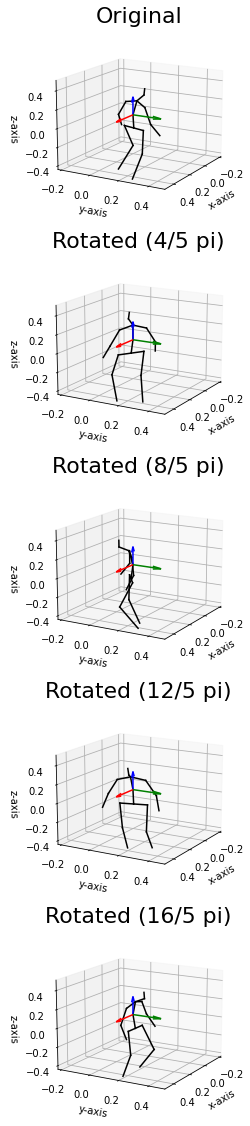

In [763]:
fig = plt.figure(figsize=(30,20))

for h in range(5):

    ax = fig.add_subplot(5, 1, h+1, projection='3d')
    ax.set_aspect('auto') ##############
    ax.view_init(15, 30)
    a=0.7
    ax.set_zlim(-0.6*a, 0.7*a)
    ax.set_xlim(-0.3*a, 0.7*a)
    ax.set_ylim(-0.3*a, 0.7*a)
    ax.set_xlabel('x-axis')
    ax.set_ylabel('y-axis')
    ax.set_zlabel('z-axis')

    ax.quiver(0,0,0,0.2,0,0, color='r') #x-axis
    ax.quiver(0,0,0,0,0.2,0, color='g') #y-axis
    ax.quiver(0,0,0,0,0,0.2, color='b') #z-axis
    
    for bone in bones_3d:
        s = bone[0]
        e = bone[1]

        col = 'black'

        x = [(aug[h][seg_idx][frame_idx][s*3]), (aug[h][seg_idx][frame_idx][e*3])]
        y = [(aug[h][seg_idx][frame_idx][s*3+1]), (aug[h][seg_idx][frame_idx][e*3+1])]
        z = [(aug[h][seg_idx][frame_idx][s*3+2]), (aug[h][seg_idx][frame_idx][e*3+2])]

        ax.plot(x, y, z, c = col)
        if h == 0:
            ax.set_title('Original', fontsize = 22)
        else:
            ax.set_title(f'Rotated ({h*4}/5 pi)', fontsize = 22)
    #     ax.text(x[0], y[0], z[0], s)
    #     ax.text(x[1], y[1], z[1], e)    
plt.savefig(f'../paper_figure/attention_graph/attention_skel_{idx_vis}.svg')
plt.show()

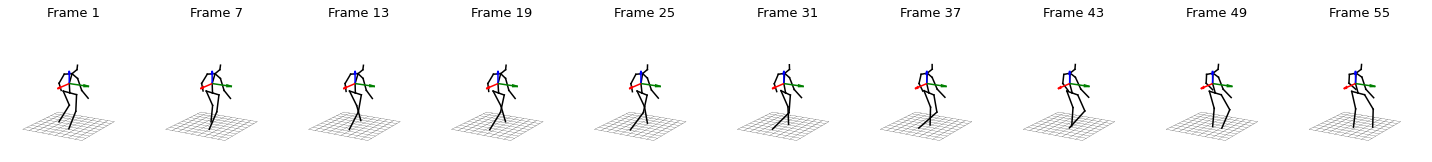

In [768]:
fig = plt.figure(figsize=(20,10))
h = 0
for frame_idx in range(10):

    ax = fig.add_subplot(1, 10, frame_idx+1, projection='3d')
    ax.set_aspect('auto') ##############
    ax.view_init(15, 30)
    a=0.7
    ax.set_zlim(-0.6*a, 0.7*a)
    ax.set_xlim(-0.3*a, 0.7*a)
    ax.set_ylim(-0.3*a, 0.7*a)
    ax.set_xlabel('x-axis')
    ax.set_ylabel('y-axis')
    ax.set_zlabel('z-axis')

    ax.quiver(0,0,0,0.2,0,0, color='r') #x-axis
    ax.quiver(0,0,0,0,0.2,0, color='g') #y-axis
    ax.quiver(0,0,0,0,0,0.2, color='b') #z-axis
    
    # Creating a grid of x and y coordinates
    x = np.linspace(-0.3, 0.3, 10)
    y = np.linspace(-0.3, 0.3, 10)
    # Plotting lines along the grid
    plane = (aug[h][seg_idx][0][3*3:3*3+3][2]+ 
         aug[h][seg_idx][0][6*3:6*3+3][2])/2
    for i in range(len(x)):
        ax.plot([x[i], x[i]], [y[0], y[-1]], [plane,plane], c='k', linewidth=0.2)
    for i in range(len(y)):
        ax.plot([x[0], x[-1]], [y[i], y[i]], [plane,plane], c='k', linewidth=0.2)
    
    for bone in bones_3d:
        s = bone[0]
        e = bone[1]

        col = 'black'

        x = [(aug[h][seg_idx][frame_idx*6][s*3]), (aug[h][seg_idx][frame_idx*6][e*3])]
        y = [(aug[h][seg_idx][frame_idx*6][s*3+1]), (aug[h][seg_idx][frame_idx*6][e*3+1])]
        z = [(aug[h][seg_idx][frame_idx*6][s*3+2]), (aug[h][seg_idx][frame_idx*6][e*3+2])]

        ax.plot(x, y, z, c = col)

        ax.set_title(f'Frame {frame_idx*6+1}', fontsize = 13)

    plt.axis('off')
    plt.tight_layout()
plt.savefig(f'../paper_figure/attention_graph/attention_skel_sequence_{idx_vis}.svg')
plt.show()

## 